In [25]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import json
import codecs

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:/Users/user/Desktop/mallet-2.0.8'

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# %matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['large','larger','small','smaller','time','higher','significant','highest','important','major','from', 're', 'edu','disaster','risk','hazard','keyword','make','makes','maked','author','study','studying','research','article','articles','review','issue','event','events','occurs','occur','results','resulted','result','case','keywords','disasters','hazards','problem','problems','project','projects','report','reports','reporting','people','pre','base','paper','papers','area','areas','crisis','year','years','day','days','parameter','parameters','base','based','provided','provide','providing','relate','related','due','part','parts','follow','follows','followed','following','high','low','result','results','find','finds','found','field','fields','show','shows','nkeyword','nkeywords'])

# Import data
with codecs.open('Article(Global)/global_final.json', 'r', 'utf-8-sig') as json_file:  
    df= pd.DataFrame(json.load(json_file))	
df.head()

# Convert to list
data = df.values.tolist()
pprint(data[:1])

[['A 30% chance of rain tomorrow": How does the public understand '
  'probabilistic weather forecasts?',
  'Abstract\n'
  'The weather forecast says that there is a "30% chance of rain," and we '
  'think we understand what it means. This quantitative statement is assumed '
  'to be unambiguous and to convey more information than does a qualitative '
  'statement like "It might rain tomorrow." Because the forecast is expressed '
  'as a single-event probability, however, it does not specify the class of '
  'events it refers to. Therefore, even numerical probabilities can be '
  'interpreted by members of the public in multiple, mutually contradictory '
  'ways. To find out whether the same statement about rain probability evokes '
  'various interpretations, we randomly surveyed pedestrians in five '
  'metropolises located in countries that have had different degrees of '
  'exposure to probabilistic forecasts--Amsterdam, Athens, Berlin, Milan, and '
  'New York. They were asked wha

In [26]:

# Tokenize words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


[['chance', 'of', 'rain', 'tomorrow', 'how', 'does', 'the', 'public', 'understand', 'probabilistic', 'weather', 'forecasts', 'abstract', 'nthe', 'weather', 'forecast', 'says', 'that', 'there', 'is', 'chance', 'of', 'rain', 'and', 'we', 'think', 'we', 'understand', 'what', 'it', 'means', 'this', 'quantitative', 'statement', 'is', 'assumed', 'to', 'be', 'unambiguous', 'and', 'to', 'convey', 'more', 'information', 'than', 'does', 'qualitative', 'statement', 'like', 'it', 'might', 'rain', 'tomorrow', 'because', 'the', 'forecast', 'is', 'expressed', 'as', 'single', 'event', 'probability', 'however', 'it', 'does', 'not', 'specify', 'the', 'class', 'of', 'events', 'it', 'refers', 'to', 'therefore', 'even', 'numerical', 'probabilities', 'can', 'be', 'interpreted', 'by', 'members', 'of', 'the', 'public', 'in', 'multiple', 'mutually', 'contradictory', 'ways', 'to', 'find', 'out', 'whether', 'the', 'same', 'statement', 'about', 'rain', 'probability', 'evokes', 'various', 'interpretations', 'we', 

In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



['chance', 'of', 'rain', 'tomorrow', 'how', 'does', 'the', 'public', 'understand', 'probabilistic', 'weather', 'forecasts', 'abstract_nthe', 'weather', 'forecast', 'says', 'that', 'there', 'is', 'chance', 'of', 'rain', 'and', 'we', 'think', 'we', 'understand', 'what', 'it', 'means', 'this', 'quantitative', 'statement', 'is', 'assumed', 'to', 'be', 'unambiguous', 'and', 'to', 'convey', 'more', 'information', 'than', 'does', 'qualitative', 'statement', 'like', 'it', 'might', 'rain', 'tomorrow', 'because', 'the', 'forecast', 'is', 'expressed', 'as', 'single', 'event', 'probability', 'however', 'it', 'does_not', 'specify', 'the', 'class', 'of', 'events', 'it', 'refers', 'to', 'therefore', 'even', 'numerical', 'probabilities', 'can', 'be', 'interpreted', 'by', 'members', 'of', 'the', 'public', 'in', 'multiple', 'mutually', 'contradictory', 'ways', 'to', 'find', 'out', 'whether', 'the', 'same', 'statement', 'about', 'rain', 'probability', 'evokes', 'various', 'interpretations', 'we', 'random

In [28]:

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['chance', 'rain', 'tomorrow', 'public', 'understand', 'probabilistic', 'weather', 'forecast', 'weather', 'forecast', 'say', 'chance', 'rain', 'think', 'mean', 'quantitative', 'statement', 'assume', 'unambiguous', 'qualitative', 'statement', 'may', 'rain', 'tomorrow', 'forecast', 'express', 'single', 'probability', 'however', 'specify', 'class', 'refer', 'therefore', 'even', 'numerical', 'probability', 'interpret', 'member', 'public', 'multiple', 'mutually', 'contradictory', 'way', 'statement', 'rain', 'probability', 'evoke', 'various', 'interpretation', 'randomly', 'survey', 'pedestrian', 'metropolis', 'locate', 'country', 'different', 'degree', 'exposure', 'probabilistic', 'forecast', 'ask', 'chance', 'rain', 'tomorrow', 'mean', 'multiple', 'choice', 'free', 'response', 'format', 'majority', 'supply', 'standard', 'meteorological', 'interpretation', 'namely', 'weather', 'condition', 'today', 'case', 'least', 'trace', 'rain', 'european', 'city', 'alternative', 'judge', 'least', 'appro

In [29]:

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 3), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 5), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 5), (48, 3), (49, 1), (50, 1), (51, 7), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 3), (58, 2), (59, 1), (60, 3), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 4), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 4)]]


In [38]:
mallet_path = 'C:/Users/user/Desktop/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=17, id2word=id2word)
# Show Topics
#pprint(ldamallet.show_topics(formatted=False))
pprint(ldamallet.print_topics(num_words=10))

[(0,
  '0.075*"vulnerability" + 0.054*"community" + 0.051*"resilience" + '
  '0.045*"social" + 0.037*"natural" + 0.021*"adaptation" + 0.015*"indicator" + '
  '0.015*"approach" + 0.014*"local" + 0.013*"framework"'),
 (1,
  '0.053*"loss" + 0.041*"impact" + 0.035*"economic" + 0.025*"cost" + '
  '0.020*"effect" + 0.016*"increase" + 0.016*"country" + 0.015*"reduce" + '
  '0.015*"global" + 0.014*"reduction"'),
 (2,
  '0.038*"safety" + 0.024*"fire" + 0.019*"accident" + 0.017*"number" + '
  '0.016*"activity" + 0.014*"work" + 0.013*"human" + 0.011*"environment" + '
  '0.009*"potential" + 0.009*"type"'),
 (3,
  '0.032*"evacuation" + 0.031*"recovery" + 0.022*"household" + 0.022*"affect" '
  '+ 0.021*"post" + 0.021*"population" + 0.020*"hurricane" + 0.019*"resident" '
  '+ 0.017*"experience" + 0.016*"survey"'),
 (4,
  '0.027*"risk" + 0.023*"policy" + 0.013*"expert" + 0.013*"process" + '
  '0.013*"public" + 0.013*"decision" + 0.011*"science" + 0.011*"environmental" '
  '+ 0.010*"scientific" + 0.009

In [39]:

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.511918914454681


In [40]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis
pyLDAvis.save_html(vis, 'global_journals.html')

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

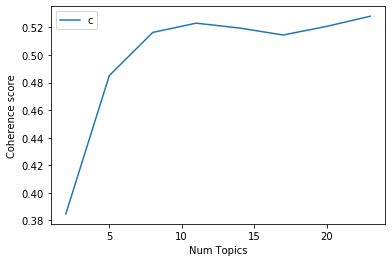

In [34]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=25, step=3)

# Show graph
limit=25; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3848
Num Topics = 5  has Coherence Value of 0.485
Num Topics = 8  has Coherence Value of 0.5163
Num Topics = 11  has Coherence Value of 0.523
Num Topics = 14  has Coherence Value of 0.5195
Num Topics = 17  has Coherence Value of 0.5145
Num Topics = 20  has Coherence Value of 0.5207
Num Topics = 23  has Coherence Value of 0.5281


In [17]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.126*"community" + 0.102*"resilience" + 0.031*"local" + 0.023*"social" + '
  '0.021*"adaptation" + 0.020*"capacity" + 0.018*"approach" + '
  '0.016*"knowledge" + 0.014*"practice" + 0.013*"framework"'),
 (1,
  '0.024*"water" + 0.024*"control" + 0.015*"result" + 0.012*"effect" + '
  '0.011*"failure" + 0.011*"test" + 0.011*"structure" + 0.011*"accident" + '
  '0.010*"condition" + 0.010*"mechanism"'),
 (2,
  '0.042*"event" + 0.034*"region" + 0.028*"drought" + 0.023*"high" + '
  '0.021*"extreme" + 0.018*"show" + 0.018*"result" + 0.017*"index" + '
  '0.015*"climate" + 0.015*"pattern"'),
 (3,
  '0.016*"humanitarian" + 0.014*"implication" + 0.014*"purpose" + '
  '0.013*"study" + 0.013*"approach" + 0.012*"article" + 0.012*"practice" + '
  '0.011*"context" + 0.010*"evidence" + 0.010*"literature"'),
 (4,
  '0.055*"preparedness" + 0.041*"perception" + 0.033*"household" + '
  '0.027*"resident" + 0.027*"experience" + 0.027*"survey" + 0.022*"influence" '
  '+ 0.021*"individual" + 0.020*"fact

In [42]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

import csv
# Write to file
df_dominant_topic.to_csv('TopicForEachDocument.csv')

In [43]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv('EachTopicText.csv')


In [44]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_csv('NumDocuofEachTopic.csv')

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(8)

NameError: name 'data_ready' is not defined

In [1]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_mallet[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

ModuleNotFoundError: No module named 'bokeh'

In [9]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_mallet.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

NameError: name 'lda_mallet' is not defined